# Setup

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import numpy as np
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data

In [95]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f'trainset: {len(trainset)}, testset: {len(testset)}')

trainset: 60000, testset: 10000


# Model

In [96]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    


# FedAvg

## Hyperparameters

In [97]:
NUM_CHILDREN = 20
LEARNING_RATE = 0.01
ROUNDS = 10
EPOCHS = 2
MAX_CNT_CLIENT=400
MAX_CNT_CLIENT_TEST=300
CNT_LABELS_NON_IID_2 = 1
BATCH_SIZE=10
PERCENT_SHARED_DATA=5
WARMUP_FRACTION=0.02
LABELS = len(np.unique(trainset.targets.numpy()))
SEED=42

## Data splitter

In [98]:
def truncate_dataset_new(dataset, num_clients, max_cnt_per_client, cnt_labels_per_client=CNT_LABELS_NON_IID_2, iid=True):
    if iid:
        max_count_per_label = (max_cnt_per_client*num_clients)//LABELS
    else:
        max_count_per_label = (num_clients*cnt_labels_per_client//LABELS+1)*(max_cnt_per_client//cnt_labels_per_client)
    label_counts = torch.bincount(dataset.targets, minlength=LABELS)  # Assuming 10 classes for MNIST
    indices_to_keep = []
    for label in range(LABELS):  # Assuming 10 classes for MNIST
        label_indices = (dataset.targets == label).nonzero().squeeze(1)
        if len(label_indices) > max_count_per_label:
            label_indices = label_indices[:max_count_per_label]
        indices_to_keep.extend(label_indices.tolist())
    
    truncated_dataset = torch.utils.data.Subset(dataset, indices_to_keep)
    # print(len(dataset), len(truncated_dataset), max_cnt_per_client)
    return truncated_dataset

def split_dataset_new(dataset, num_clients, max_cnt_per_client, iid=True, cnt_labels_per_client=None, output_file="output.txt"):
    truncated_dataset = truncate_dataset_new(dataset, num_clients,cnt_labels_per_client=cnt_labels_per_client, iid=iid, max_cnt_per_client=max_cnt_per_client)
    indices = list(range(len(truncated_dataset)))
    num_samples_per_client = max_cnt_per_client
    # print(num_samples_per_client)
    if iid:
        random.shuffle(indices)
        splits = [indices[i*num_samples_per_client:(i+1)*num_samples_per_client] for i in range(num_clients)]
        subsets = [torch.utils.data.Subset(truncated_dataset, indices) for indices in splits]
        total = 0
    else:
        indices = sorted(indices, key=lambda i: truncated_dataset.dataset.targets[i])
        cur_index_per_label = [0]*LABELS
        cur_pointer = 0
        splits = []
        num_samples_per_client_per_label = max_cnt_per_client//cnt_labels_per_client
        max_cnt_per_label = (num_clients*cnt_labels_per_client//LABELS+1)*num_samples_per_client_per_label
        for client in range(num_clients):
            for i in range(cnt_labels_per_client):
                start = cur_index_per_label[cur_pointer]*num_samples_per_client_per_label+cur_pointer*max_cnt_per_label
                splits.append(indices[start: start+num_samples_per_client_per_label])
                cur_index_per_label[cur_pointer]=cur_index_per_label[cur_pointer]+1
                cur_pointer=(cur_pointer+1) % LABELS
        # splits = [indices[i*num_samples_per_client:(i+1)*num_samples_per_client] for i in range(num_clients)]
        subsets=[]
        val=0
        for index in range(num_clients):
            cur = splits[val]
            for count in range(1, cnt_labels_per_client):
                cur.extend(splits[val+count])
            subsets.append(torch.utils.data.Subset(truncated_dataset, cur))
            val = val+cnt_labels_per_client

    total = 0
    if output_file is not None:
        with open(output_file, "w") as f:
            for i, subset in enumerate(subsets):
                labels = [truncated_dataset.dataset.targets[i] for i in subset.indices]
                label_counts = torch.bincount(torch.tensor(labels, dtype=torch.long), minlength=10)  # Assuming 10 classes for MNIST
                f.write(f"Client {i} label counts:\n")
                for j, count in enumerate(label_counts):
                    f.write(f"Label {j}: {count.item()}\n")
                    total += count.item()
                f.write("\n")
            f.write(f"Total count of dataset: {total}\n")
    return subsets

In [99]:
def generate_iid_set(dataset, percent, max_cnt_per_client=MAX_CNT_CLIENT):
    total_size = (percent*max_cnt_per_client)//100
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices_to_keep = [indices[i] for i in range(total_size)]
    truncated_dataset = torch.utils.data.Subset(dataset, indices_to_keep)
    return truncated_dataset

In [100]:
def generate_warmup_set(dataset, warmup_fraction):
    total_size = (int)(warmup_fraction*len(dataset))
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices_to_keep = [indices[i] for i in range(total_size)]
    truncated_dataset = torch.utils.data.Subset(dataset, indices_to_keep)
    return truncated_dataset

## Client and host

In [101]:
class CLIENT():
    def __init__(self,train_loader,test_loader,modelClass,optim,loss_function,device,learning_rate,epochs):
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model =  modelClass().to(self.device)
        self.learning_rate = learning_rate
        self.loss_func = loss_function().to(self.device)
        self.epochs = epochs
        self.optimizer =  optim(self.model.parameters(),lr=learning_rate)
        self.results = []
    def update_params_to(self,model):
        self.model.load_state_dict(model.state_dict())
    def train_round(self):
        for epoch in range(self.epochs):
            print(f"E{epoch+1} ",end="")
            self.model.train()
            running_loss = 0.0
            for inputs,labels in self.train_loader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                self.model.zero_grad()
                output = self.model(inputs)
                # print(output.shape)
                # print(torch.argmax(output,dim=1).shape)
                # print(labels.shape)
                loss = self.loss_func(output, labels)
                loss.backward()
                self.optimizer.step()
                # print(f" loss:{loss.item()} ")
                running_loss += loss.item()*inputs.size(0)
            # print(f"running loss:{running_loss} ")
            testing_loss = 0.0
            self.model.eval()
            with torch.no_grad():
                for inputs,labels in self.test_loader:
                    inputs,labels = inputs.to(self.device),labels.to(self.device)
                    output = self.model(inputs)
                    testing_loss+=self.loss_func(output,labels).sum().item()
                avg_loss = running_loss/len(self.train_loader.dataset)
                # print(f"avg loss:{avg_loss}\n")
            self.results.append(avg_loss)
        print("",end= "\n")

In [102]:
class HOST():
    def __init__(self,model,optimizer,loss_function,learning_rate,device,testset,trainset,epochs,rounds,
                 cnt_labels_noniid=CNT_LABELS_NON_IID_2,num_clients=NUM_CHILDREN,
                 max_cnt_per_client_train=MAX_CNT_CLIENT, max_cnt_per_client_test=MAX_CNT_CLIENT_TEST,
                 export=False,shared_data=PERCENT_SHARED_DATA,
                 warmup=False,warmup_fraction=WARMUP_FRACTION,warmup_epochs=1,
                 batch_size=BATCH_SIZE,iid=True,seed=None):
        if seed:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        self.model = model().to(device)
        self.central_train_model = model().to(device)
        self.central_train_model.load_state_dict(self.model.state_dict())
        self.central_train_optim =  optimizer(self.central_train_model.parameters(), lr=learning_rate)
        self.device=device
        self.epochs = epochs
        self.rounds = rounds
        self.export = export
        self.num_clients = num_clients
        self.loss_func = loss_function().to(device)
        self.optim = optimizer(self.model.parameters(),lr=learning_rate)
        self.lr = learning_rate
        self.rounds = rounds
        self.trainset = trainset
        self.testset = testset
        self.cnt_labels=cnt_labels_noniid
        self.train_full_dataloader = torch.utils.data.DataLoader(truncate_dataset_new(self.trainset, iid=iid, max_cnt_per_client=max_cnt_per_client_train,num_clients=self.num_clients),batch_size=self.num_clients*batch_size,shuffle=True)
        self.test_full_dataloader = torch.utils.data.DataLoader(truncate_dataset_new(self.testset, iid=iid, max_cnt_per_client=max_cnt_per_client_test, num_clients=self.num_clients),batch_size=self.num_clients*batch_size,shuffle=True)
        self.warmup_fraction = warmup_fraction*(len(self.train_full_dataloader)*num_clients*batch_size*1.0/len(trainset))
        self.clients = []
        self.results = []
        self.accuracies = []
        self.central_train_results = []
        self.batch_size = batch_size
        self.client_sample_sizes = [len(trainset)//self.num_clients]*self.num_clients
        self.train_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=False) 
                     for dataset in split_dataset_new(trainset, self.num_clients,iid=iid, max_cnt_per_client=max_cnt_per_client_train,cnt_labels_per_client=self.cnt_labels)]
        self.test_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=False) 
                    for dataset in split_dataset_new(testset, self.num_clients,iid=iid, max_cnt_per_client=max_cnt_per_client_test,cnt_labels_per_client=self.cnt_labels)]
        self.layer_names = []
        self.divergences_per_layer = {name: [] for name, _ in self.model.named_parameters()}
        self.subset_iid_data=None
        if warmup:
            self.warm_train = generate_warmup_set(trainset, self.warmup_fraction)
            # self.warm_test = generate_iid_set(testset, warmup_fraction*100)
            optim = optimizer(self.model.parameters(), lr=learning_rate)
            self.warm_train = torch.utils.data.DataLoader(
                self.warm_train,batch_size=self.batch_size,shuffle=True
            )
            # self.warm_test = torch.utils.data.DataLoader(
            #     self.warm_test,batch_size=self.batch_size,shuffle=True
            # )

            print("Warmup: ")
            for epoch in range(warmup_epochs):
                print(f"E{epoch+1} ",end=" ")
                self.model.train()
                running_loss=0.0
                for inputs,labels in self.warm_train:
                    inputs,labels = inputs.to(device),labels.to(device)
                    self.model.zero_grad()
                    output = self.model(inputs)
                    loss = self.loss_func(output, labels)
                    loss.backward()
                    optim.step()
                    running_loss += loss.item()*inputs.size(0)
            print()
            self.central_train_model.load_state_dict(self.model.state_dict())
        if self.export:
            self.subset_iid_data = torch.utils.data.DataLoader(generate_iid_set(self.trainset, shared_data), batch_size=self.batch_size, shuffle=True)
            for i in range(self.num_clients):
                new_client = CLIENT(
                    train_loader=torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([self.train_dataloaders[i].dataset, self.subset_iid_data.dataset]), batch_size=self.batch_size, shuffle=True),
                    test_loader=self.test_dataloaders[i],
                    device=self.device,
                    modelClass=model,
                    optim=optimizer,
                    loss_function=loss_function,
                    learning_rate=learning_rate,
                    epochs=epochs
                )
                new_client.update_params_to(self.model)
                self.clients.append(new_client)
        else:
            for i in range(self.num_clients):
                new_client = CLIENT(
                    train_loader=self.train_dataloaders[i],
                    test_loader=self.test_dataloaders[i],
                    device=self.device,
                    modelClass=model,
                    optim=optimizer,
                    loss_function=loss_function,
                    learning_rate=learning_rate,
                    epochs=epochs
                )
                new_client.update_params_to(self.model)
                self.clients.append(new_client)
        # print(len(self.train_full_dataloader))
    def aggr_round(self):
        local_params= []
        for i in range(self.num_clients):
            print(f"Client {i} is training.")
            client = self.clients[i]
            client.train_round()
            state_dict = client.model.state_dict()
            for key,value in state_dict.items():
                state_dict[key] = value/self.num_clients
            # state_dict = state_dict/self.num_clients
            local_params.append(state_dict)
        weighted_param_sum = local_params[0]
        for params in local_params[1:]:
            for key,value in params.items():
                weighted_param_sum[key] = weighted_param_sum.get(key) + value
        self.model.load_state_dict(weighted_param_sum)
        for client in self.clients:
            client.update_params_to(self.model)
        with torch.no_grad():
            self.model.eval()
            test_loss = 0.0
            for inputs,labels in self.test_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                output = self.model(inputs)
                test_loss+=self.loss_func(output,labels)
            avg_loss = test_loss/len(self.test_full_dataloader.dataset)
            # self.results.append(avg_loss)
    def test_aggr(self):
        self.model.eval()
        correct = 0
        total = 0
        running_loss=0.0
        with torch.no_grad():
            for inputs,labels in self.test_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                outputs = self.model(inputs)
                loss=self.loss_func(outputs, labels)
                running_loss+=loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct/total
        self.accuracies.append(accuracy)
        avg_loss = (running_loss/len(self.test_full_dataloader))
        return avg_loss
    def test_central(self):
        self.central_train_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs,labels in self.test_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                outputs = self.central_train_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    def do_rounds(self):
        for i in range(self.rounds):
            print(f"Round: {i+1}")
            self.aggr_round()
            self.store_divergence()
            loss = self.test_aggr()
            self.results.append(loss)
            print(f"Loss: {loss}")
    def central_train(self):
        for epoch in range(self.epochs*self.rounds):
            print(f"E{epoch+1} ",end="")
            self.central_train_model.train()
            running_loss = 0.0
            for inputs,labels in self.train_full_dataloader:
                inputs,labels = inputs.to(self.device),labels.to(self.device)
                self.central_train_model.zero_grad()
                output = self.central_train_model(inputs)
                # print(output.shape)
                # print(torch.argmax(output,dim=1).shape)
                # print(labels.shape)
                loss = self.loss_func(output, labels)
                loss.backward()
                self.central_train_optim.step()
                running_loss += loss.item()*inputs.size(0)
            testing_loss = 0.0
            self.model.eval()
            with torch.no_grad():
                for inputs,labels in self.test_full_dataloader:
                    inputs,labels = inputs.to(self.device),labels.to(self.device)
                    output = self.model(inputs)
                    testing_loss+=self.loss_func(output,labels).sum().item()
                avg_loss = (running_loss/len(self.test_full_dataloader.dataset))
            self.central_train_results.append(avg_loss)
            # self.central_train_results.append(running_loss)
        print("",end= "\n")
    def dispaly(self,plot_clients=False,plot_epochs=True):
        if plot_clients:
            for i in range(self.num_clients):
                client = self.clients[i]
                plt.plot(client.results,label=f"{i}")
        plt.plot(self.central_train_results,label=f"C")
        res_x = [(i+1)*self.epochs-1 for i in range(self.rounds)]
        res_y = self.results
        plt.scatter(res_x,res_y,label="F")
        if plot_epochs:
            for i in range(1,self.rounds+1):
                plt.axvline(x=i*self.epochs-1,color='b')
        plt.legend()
        plt.show()
    def run_central_and_federated_and_display(self,plot_clients=False,plot_epochs=True):
        print("Training centralized model:")
        self.central_train()
        central_accuracy = self.test_central()
        print(f"Central Accuracy: {100*central_accuracy}")
        self.do_rounds()
        self.dispaly(plot_clients=plot_clients,plot_epochs=plot_epochs)
    def plot_divergence(self):
        central_stuff = dict()
        federated_stuff = dict()
        diff = dict()

        for name,layer in self.model.named_parameters():
            federated_stuff[name] = np.array(layer.detach().to("cpu"))

        for name,layer in self.central_train_model.named_parameters():
            central_stuff[name] = np.array(layer.detach().to("cpu"))

        for layer_name in central_stuff.keys():
            diff[layer_name] = np.std((central_stuff[layer_name]-federated_stuff[layer_name]))

        plt.figure(figsize=(8,6))
        plt.bar(diff.keys( ), diff.values())
        for i, value in enumerate(diff.values()):
            plt.annotate(str(round(value, 5)), xy=(i, value), ha='center', va='bottom')
        plt.ylabel("Std. Dev. of difference")
        plt.xlabel("Layer")
        plt.xticks(rotation=45)

        plt.show()
    def store_divergence(self):
        central_stuff = dict()
        federated_stuff = dict()

        for name, layer in self.model.named_parameters():
            federated_stuff[name] = np.array(layer.detach().to("cpu"))

        for name, layer in self.central_train_model.named_parameters():
            central_stuff[name] = np.array(layer.detach().to("cpu"))

        for layer_name in central_stuff.keys():
            divergence = np.std((central_stuff[layer_name] - federated_stuff[layer_name]))
            self.divergences_per_layer[layer_name].append(divergence)
            if len(self.layer_names) == 0 or layer_name not in self.layer_names:
                self.layer_names.append(layer_name)
    def plot_weight_divergence(self):
        plt.figure(figsize=(12, 8))
        for layer_name in self.layer_names:
            plt.plot(range(1, self.rounds + 1), self.divergences_per_layer[layer_name], marker='o', label=layer_name)
        plt.xlabel('Communication Rounds')
        plt.ylabel('Weight Divergence')
        plt.title('Weight Divergence for Each Layer vs Communication Rounds')
        plt.legend()
        plt.grid(True)
        plt.show()
    def plot_accuracy_per_round(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.rounds + 1), self.accuracies, marker='o', )
        plt.xlabel('Communication Rounds')
        plt.ylabel('Fed Avg Accuracy')
        plt.title('Accuracy vs Communication Rounds')
        plt.grid(True)
        plt.show()


## IID

In [103]:
host0 = HOST(
    model=CNN_MNIST,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    seed=SEED
)

Training centralized model:
E1 

E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 94.25
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 1.0324312627315522
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is t

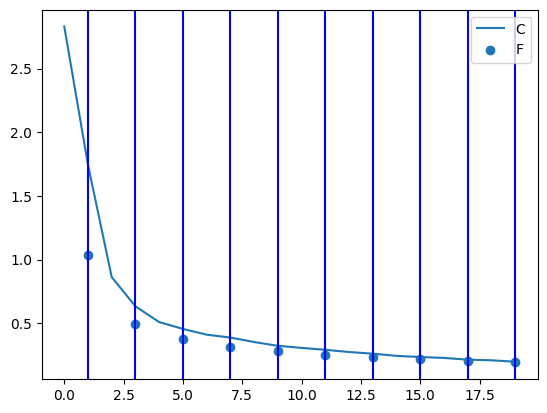

In [104]:
host0.run_central_and_federated_and_display()

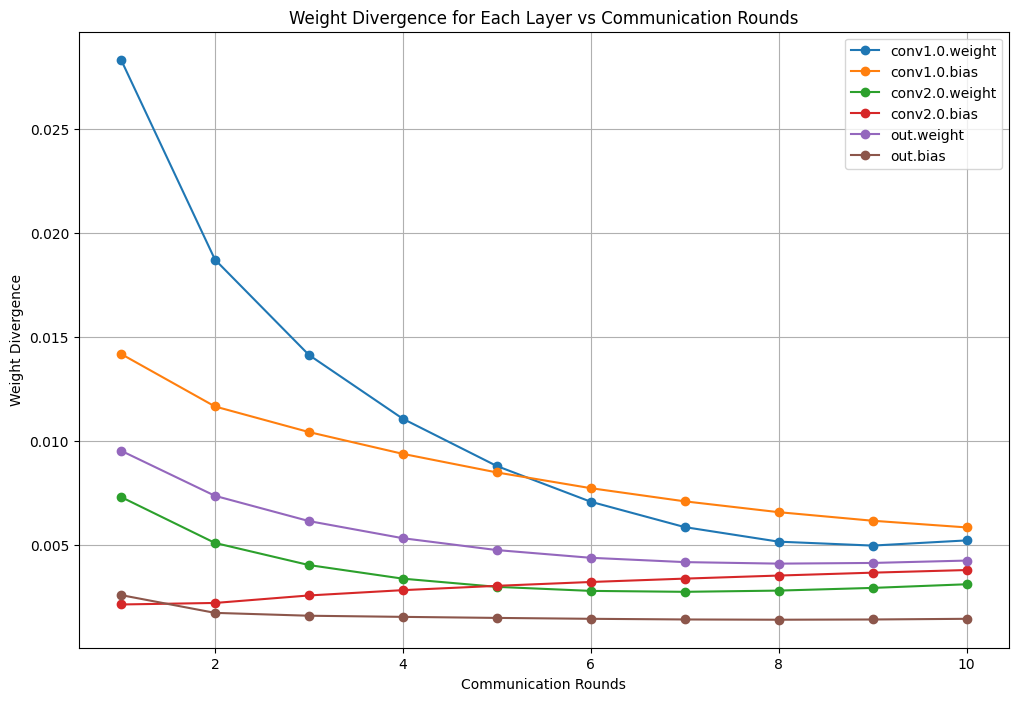

In [105]:
host0.plot_weight_divergence()

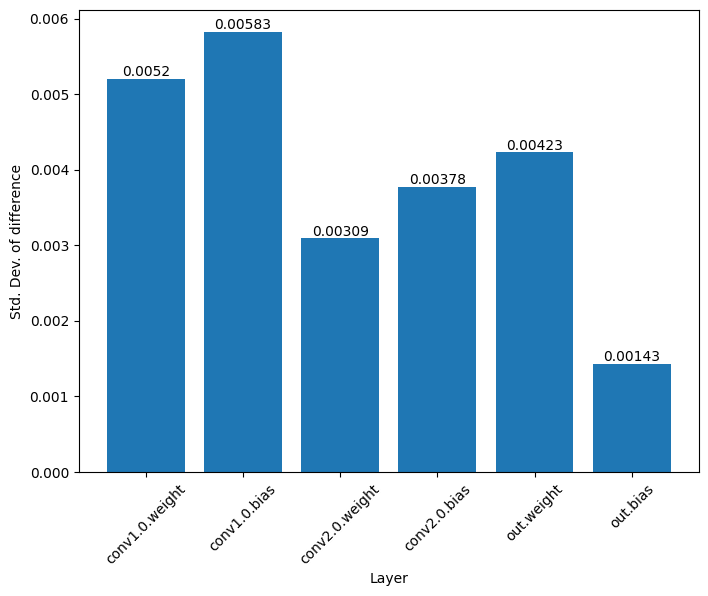

In [106]:
host0.plot_divergence()

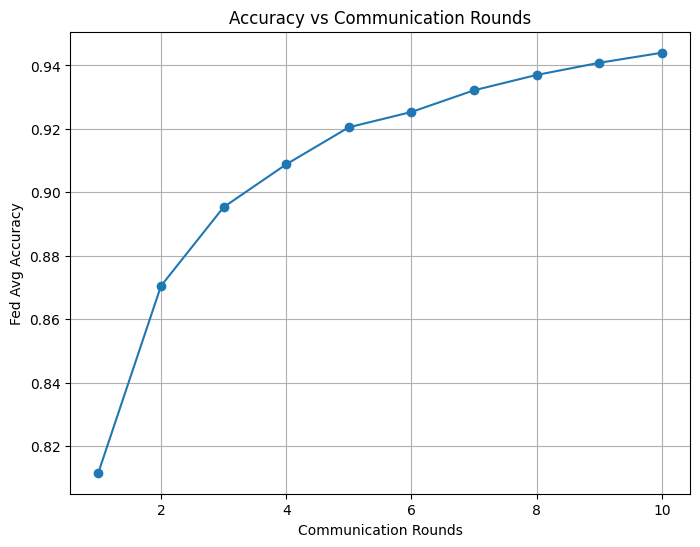

In [107]:
host0.plot_accuracy_per_round()

## Non IID

In [108]:
host1 = HOST(
    model=CNN_MNIST,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 96.31895017793595
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 2.246004083421495
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 


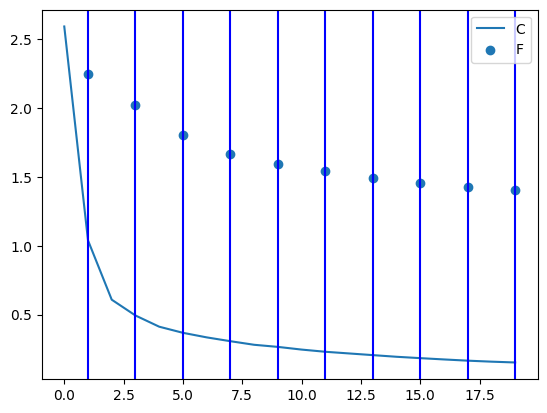

In [109]:
host1.run_central_and_federated_and_display()

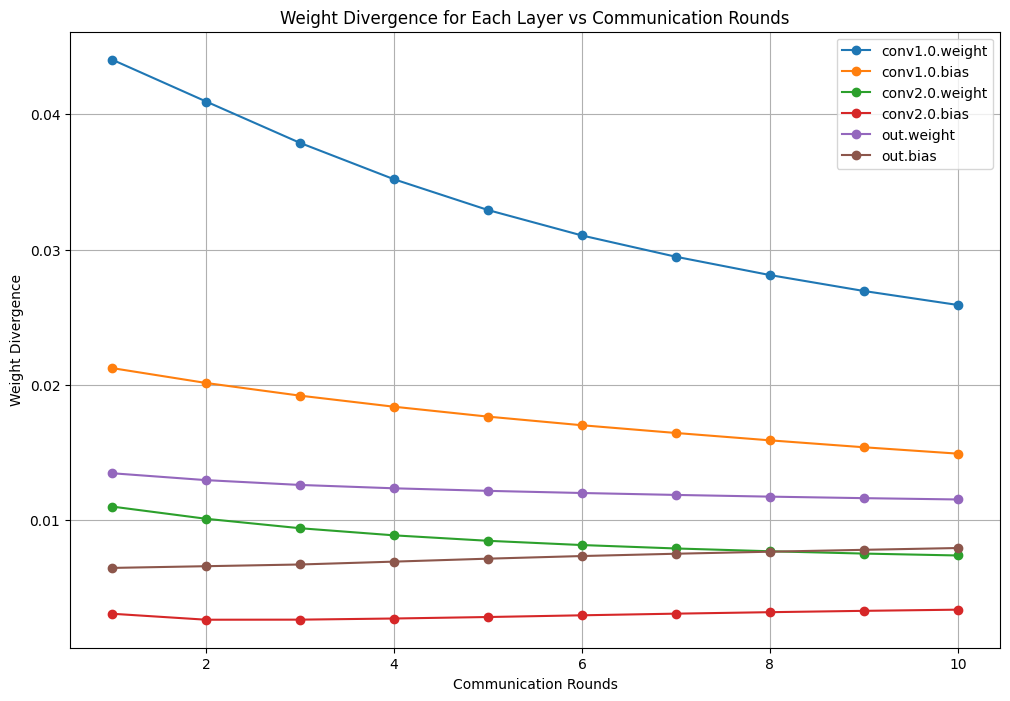

In [110]:
host1.plot_weight_divergence()

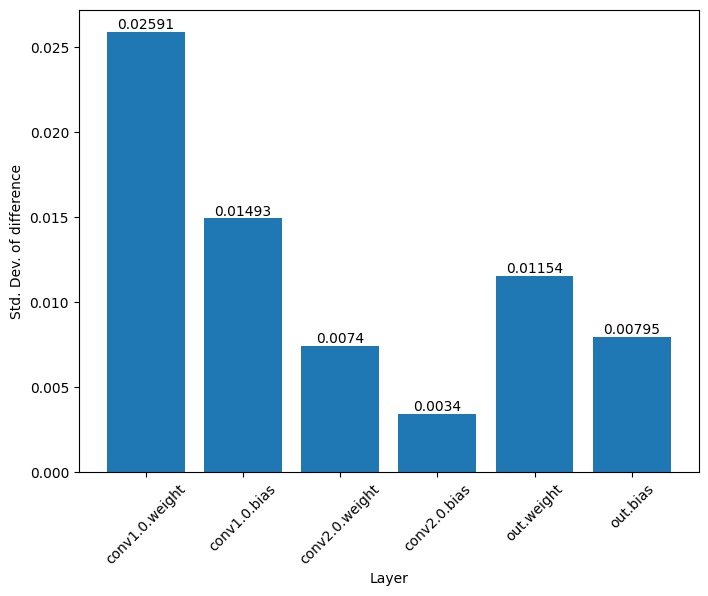

In [111]:
host1.plot_divergence()

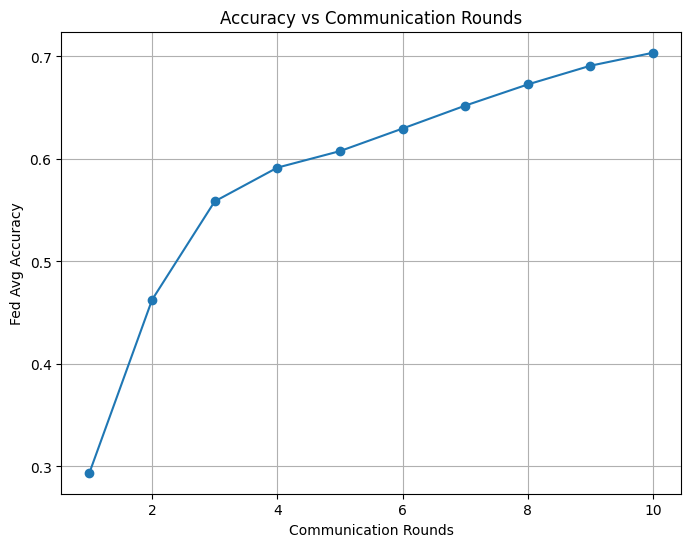

In [112]:
host1.plot_accuracy_per_round()

## Sharing a small subset of IID data

In [113]:
host2 = HOST(
    model=CNN_MNIST,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    export=True,
    shared_data=PERCENT_SHARED_DATA,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 96.31895017793595
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 1.7436024241977268
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

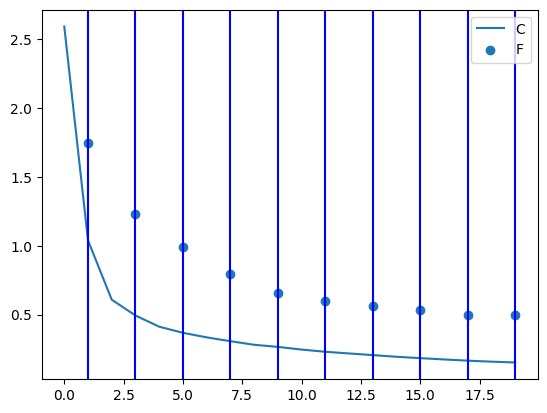

In [114]:
host2.run_central_and_federated_and_display()

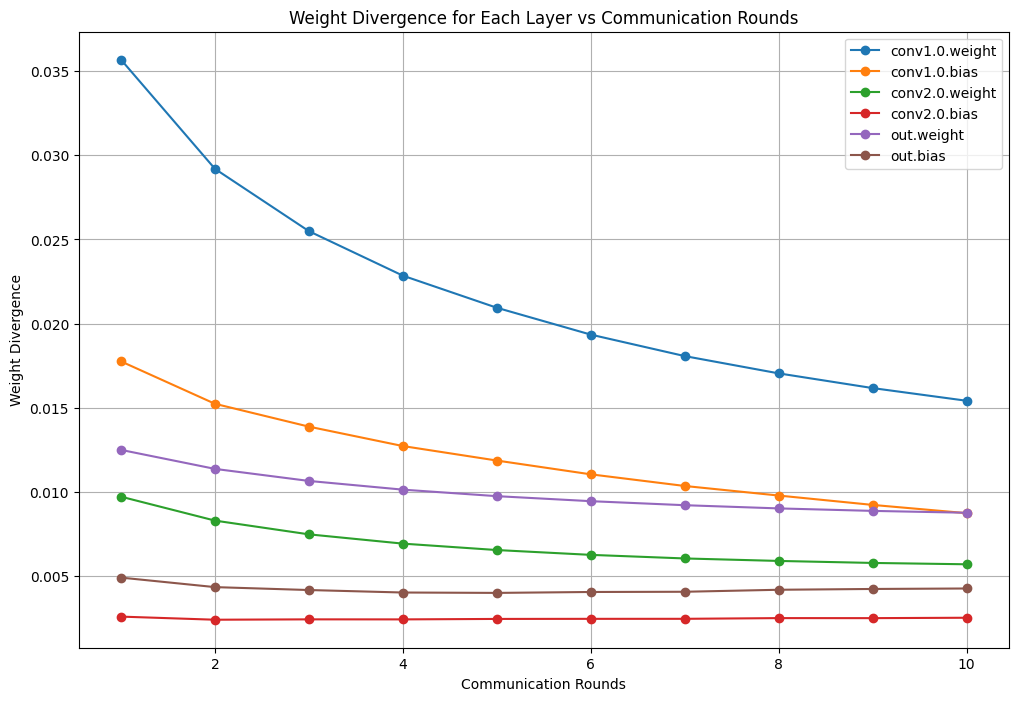

In [115]:
host2.plot_weight_divergence()

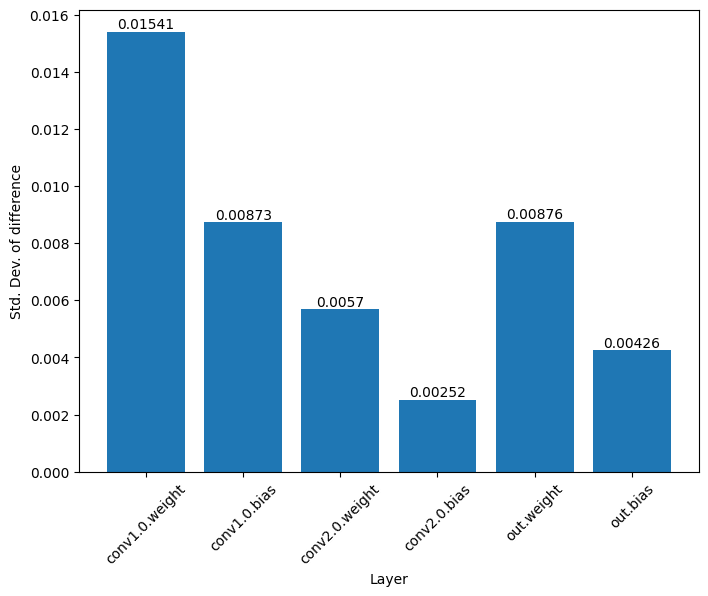

In [116]:
host2.plot_divergence()

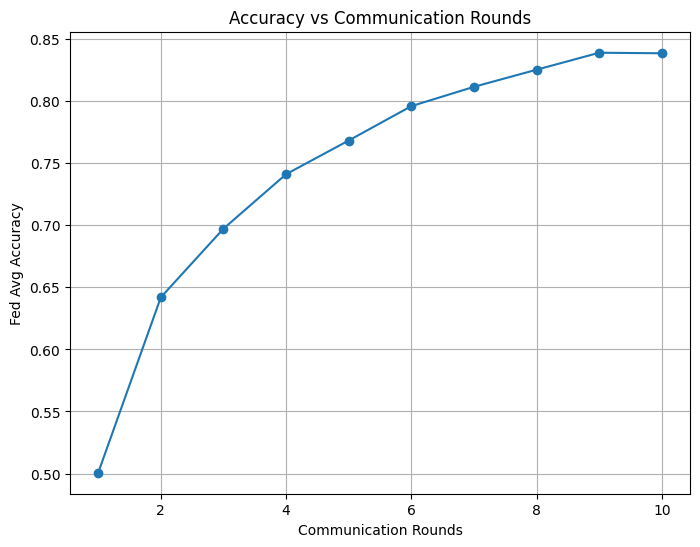

In [117]:
host2.plot_accuracy_per_round()

## Comparing Class-2 Non-IID & IID

In [118]:
host3 = HOST(
    model=CNN_MNIST,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    cnt_labels_noniid=2,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 96.31895017793595
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 2.093283780415853
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 


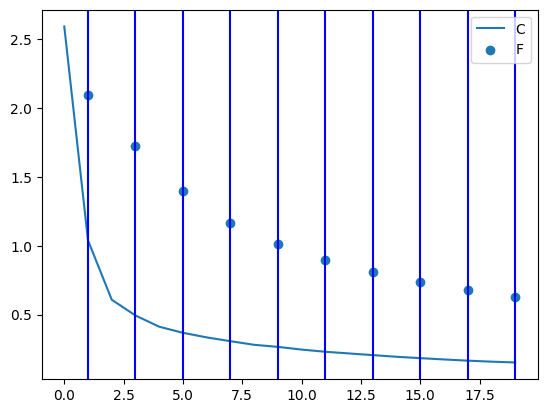

In [119]:
host3.run_central_and_federated_and_display()

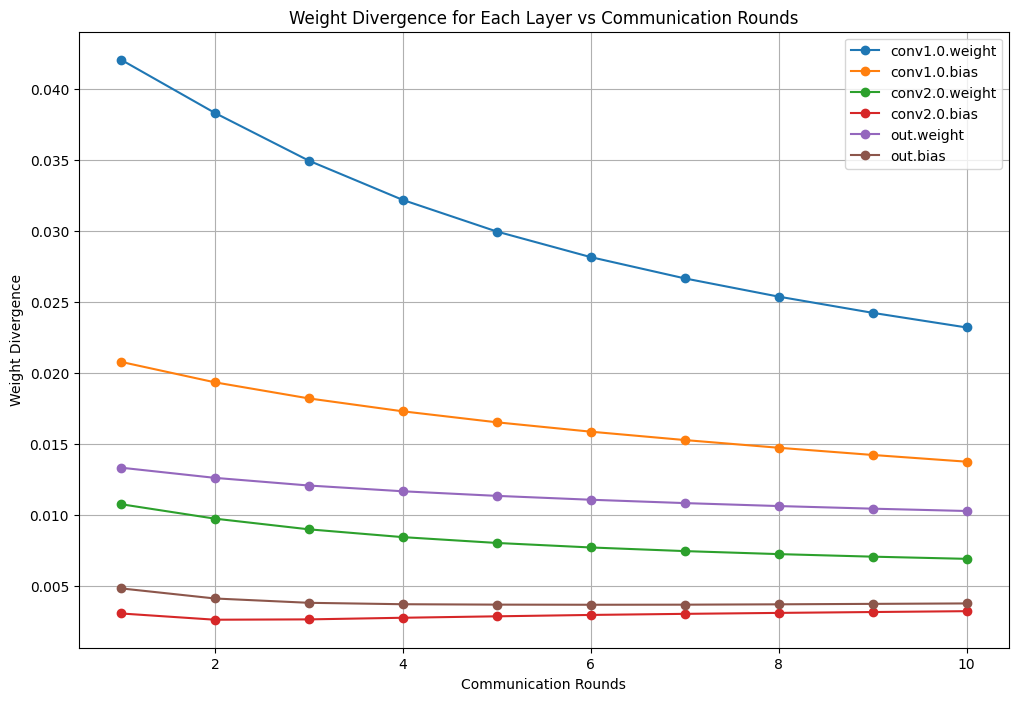

In [120]:
host3.plot_weight_divergence()

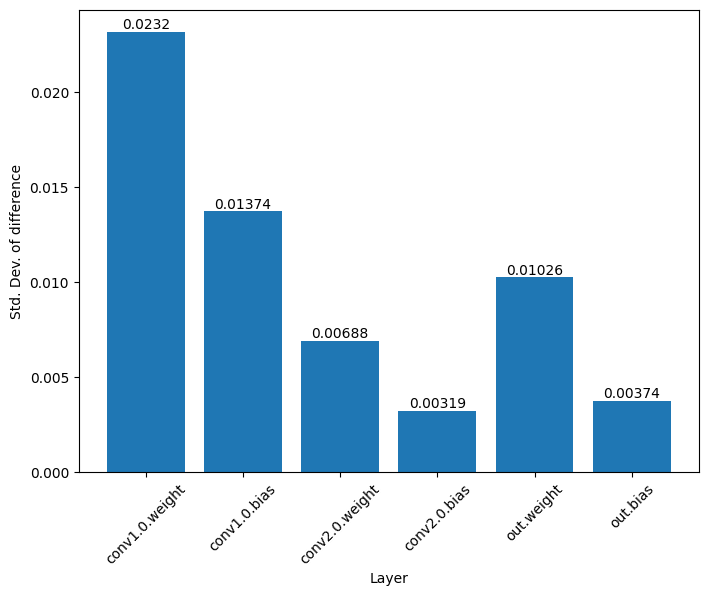

In [121]:
host3.plot_divergence()

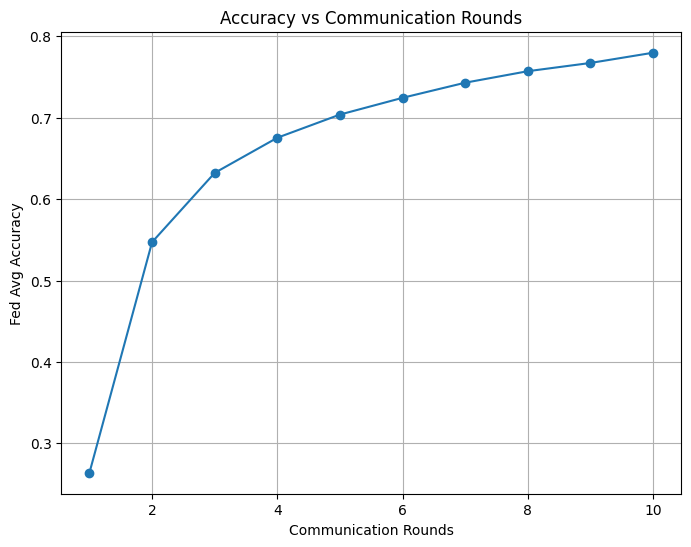

In [122]:
host3.plot_accuracy_per_round()

In [123]:
host4 = HOST(
    model=CNN_MNIST,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    cnt_labels_noniid=5,
    seed=SEED
)

Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 96.31895017793595
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 1.9939759916729398
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

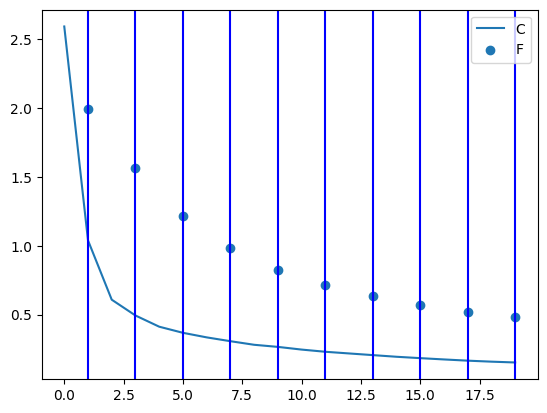

In [124]:
host4.run_central_and_federated_and_display()

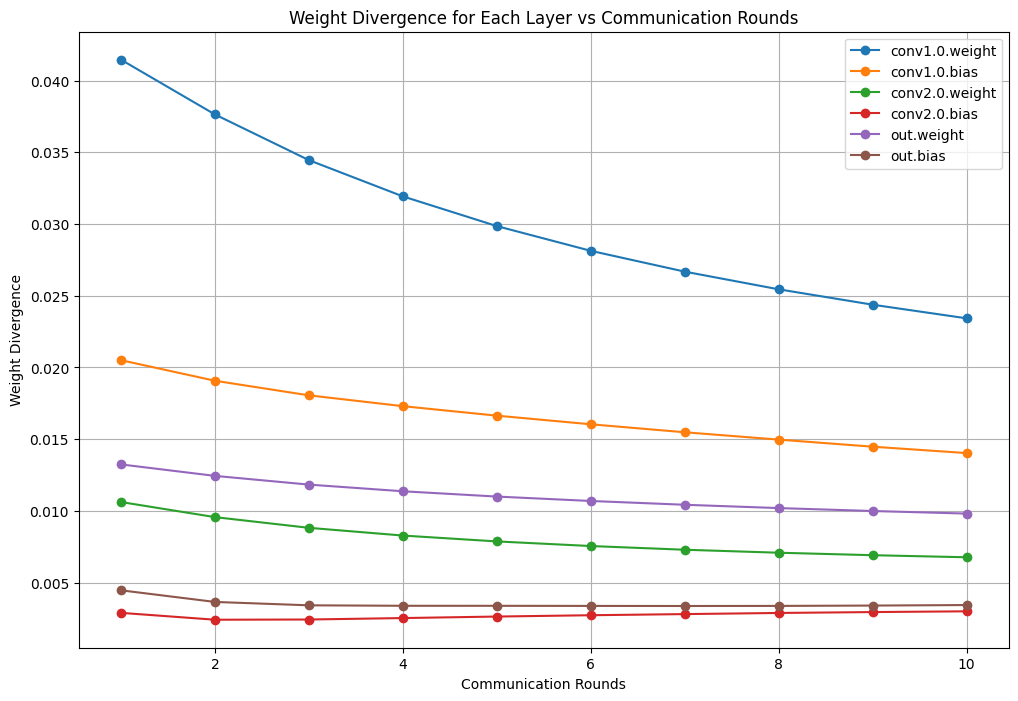

In [125]:
host4.plot_weight_divergence()

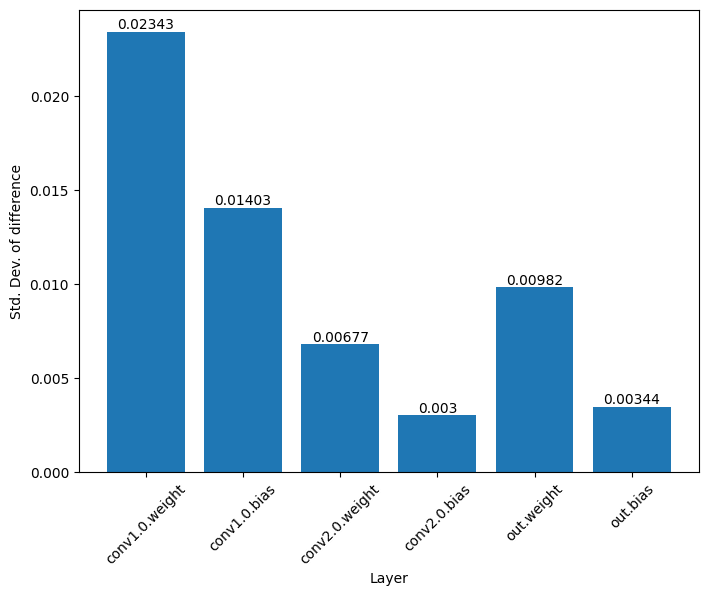

In [126]:
host4.plot_divergence()

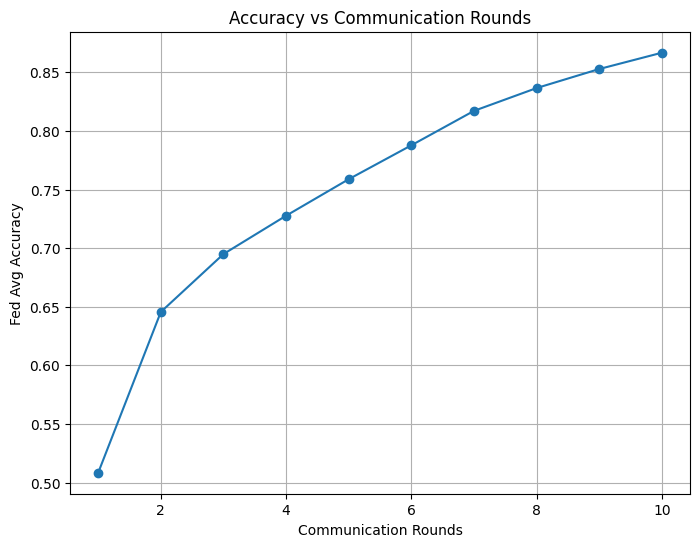

In [127]:
host4.plot_accuracy_per_round()

## Implementing Warm up Model

In [128]:
host5 = HOST(
    model=CNN_MNIST,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    warmup=True,
    warmup_epochs=2,
    warmup_fraction=WARMUP_FRACTION,
    seed=SEED
)

Warmup: 
E1  E2  


Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 96.67482206405694
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 1.6147064632839627
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

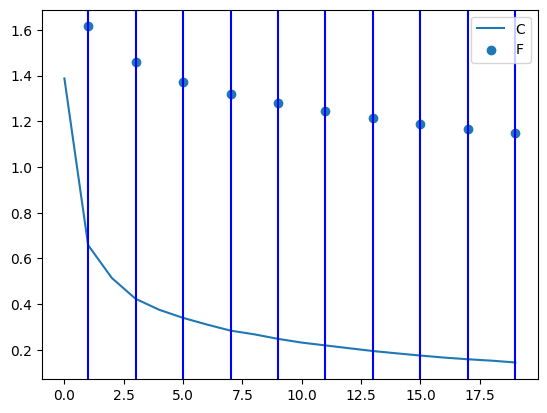

In [129]:
host5.run_central_and_federated_and_display()

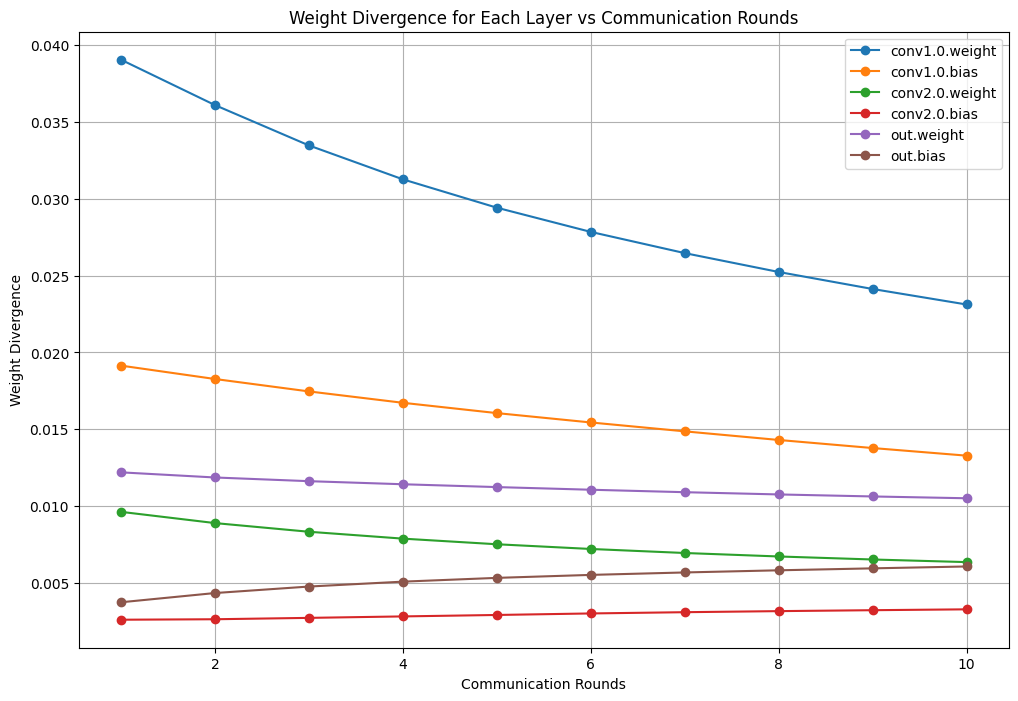

In [130]:
host5.plot_weight_divergence()

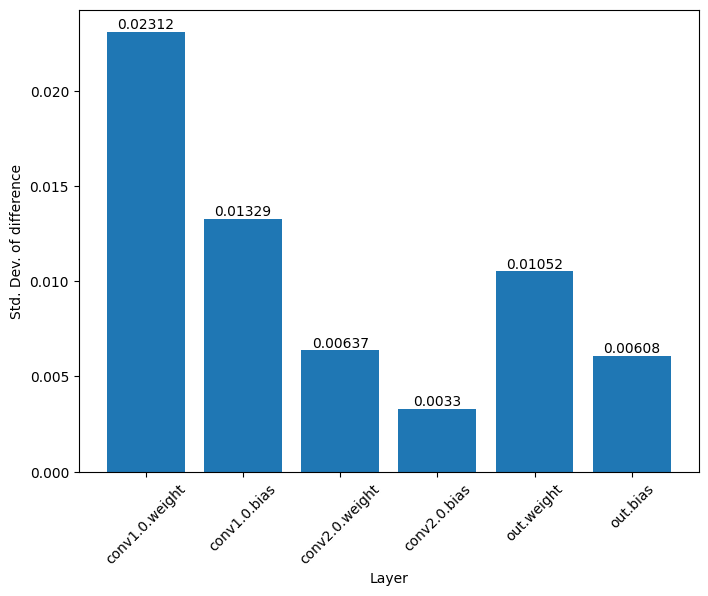

In [131]:
host5.plot_divergence()

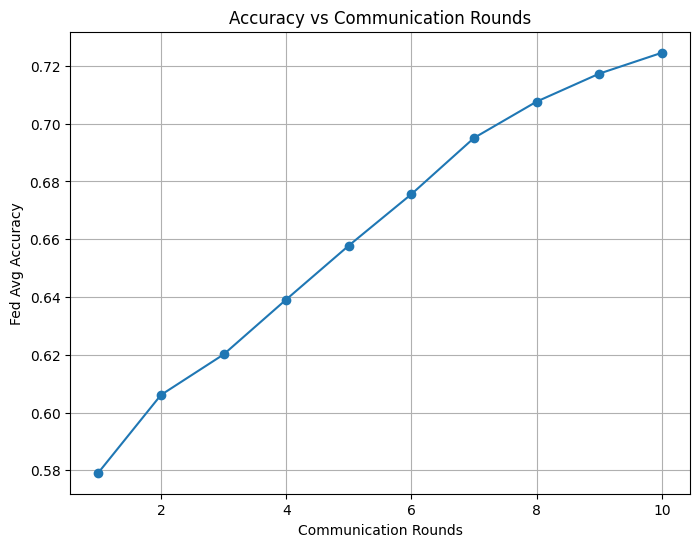

In [132]:
host5.plot_accuracy_per_round()

## Warmup with global IID subset

In [133]:
host6 = HOST(
    model=CNN_MNIST,
    optimizer=optim.SGD,
    loss_function=nn.CrossEntropyLoss,
    learning_rate=LEARNING_RATE,
    device=device,
    num_clients=NUM_CHILDREN,
    testset=testset,
    trainset=trainset,
    epochs=EPOCHS,
    rounds=ROUNDS,
    iid=False,
    warmup=True,
    warmup_epochs=2,
    warmup_fraction=WARMUP_FRACTION,
    export=True,
    shared_data=PERCENT_SHARED_DATA,
    seed=SEED
)

Warmup: 
E1  E2  


Training centralized model:
E1 E2 E3 E4 E5 E6 E7 E8 E9 E10 E11 E12 E13 E14 E15 E16 E17 E18 E19 E20 
Central Accuracy: 96.66370106761566
Round: 1
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 
Client 8 is training.
E1 E2 
Client 9 is training.
E1 E2 
Client 10 is training.
E1 E2 
Client 11 is training.
E1 E2 
Client 12 is training.
E1 E2 
Client 13 is training.
E1 E2 
Client 14 is training.
E1 E2 
Client 15 is training.
E1 E2 
Client 16 is training.
E1 E2 
Client 17 is training.
E1 E2 
Client 18 is training.
E1 E2 
Client 19 is training.
E1 E2 
Loss: 1.2805910719765556
Round: 2
Client 0 is training.
E1 E2 
Client 1 is training.
E1 E2 
Client 2 is training.
E1 E2 
Client 3 is training.
E1 E2 
Client 4 is training.
E1 E2 
Client 5 is training.
E1 E2 
Client 6 is training.
E1 E2 
Client 7 is training.
E1 E2 

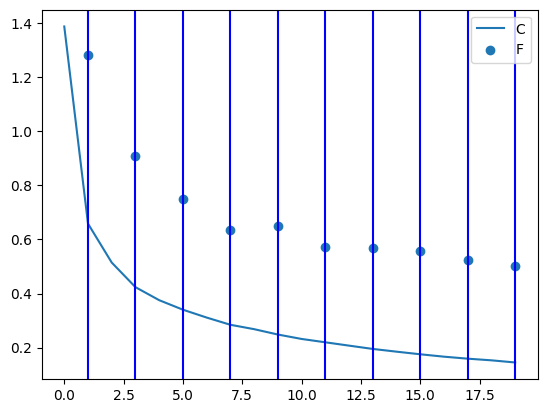

In [134]:
host6.run_central_and_federated_and_display()

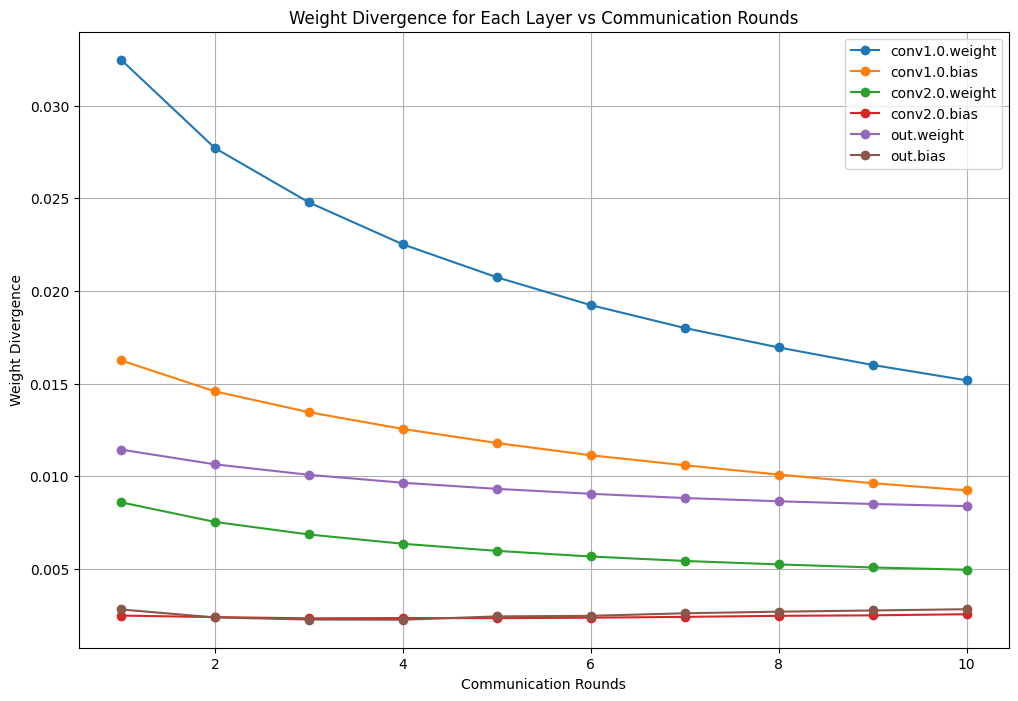

In [135]:
host6.plot_weight_divergence()

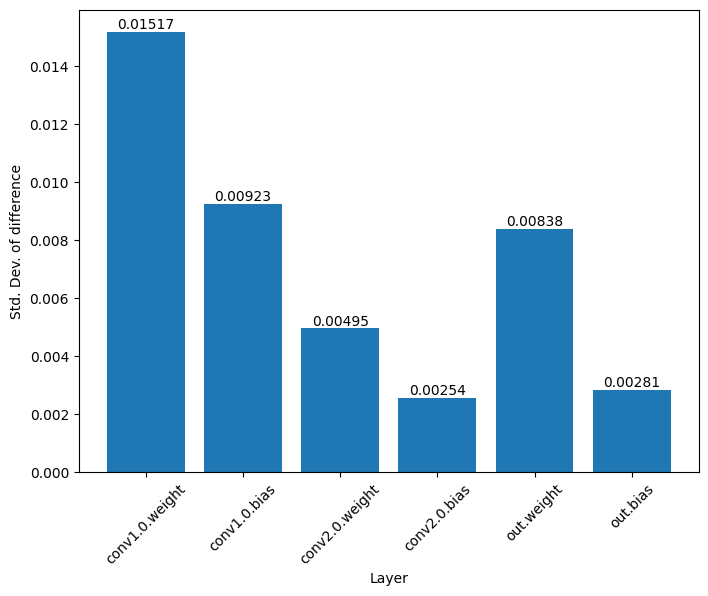

In [136]:
host6.plot_divergence()

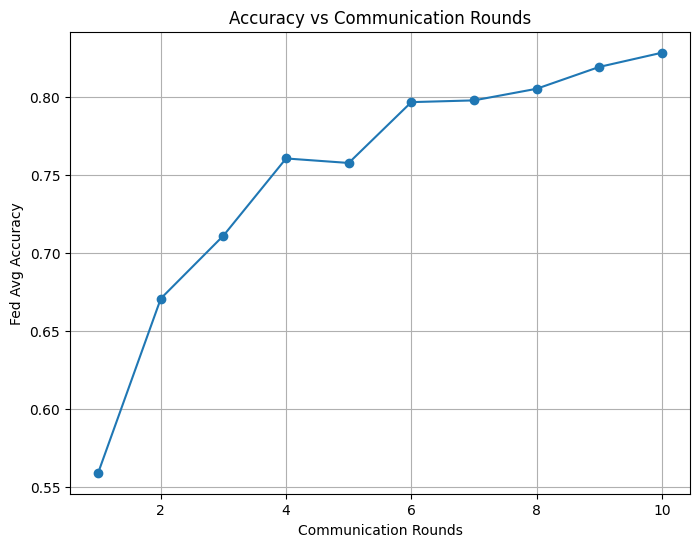

In [137]:
host6.plot_accuracy_per_round()

# Results

In [143]:
hosts = [host0,host1,host3,host4,host2,host5,host6]
host_names = ["IID","Non-IID (1)","Non-IID (2)","Non-IID (5)","Non-IID (1) w Sharing [10%]","Non-IID (1) w Warmup [1% 2E]","Non-IID (1) w Warmup [1% 2E] Sharing [10%]"]

In [144]:
def compare_divergence(hosts):
    n=0
    layer_names=[]
    for name,layer in hosts[0].model.named_parameters():
        n+=1
        layer_names.append(name)
    r = np.arange(n)
    bar_width=0.1

    plt.figure(figsize=(15,6))
    for i in range(len(hosts)):
        central_stuff = dict()
        federated_stuff = dict()
        diff = dict()

        for name,layer in hosts[i].model.named_parameters():
            federated_stuff[name] = np.array(layer.detach().to("cpu"))

        for name,layer in hosts[i].central_train_model.named_parameters():
            central_stuff[name] = np.array(layer.detach().to("cpu"))

        for layer_name in central_stuff.keys():
            diff[layer_name] = np.std((central_stuff[layer_name]-federated_stuff[layer_name]))
        
        plt.bar(r+bar_width*i, diff.values(),width=bar_width,label=host_names[i])

    plt.grid(axis='y')
    plt.xticks(r+bar_width*(n//2),layer_names)
    plt.legend()
    plt.show()

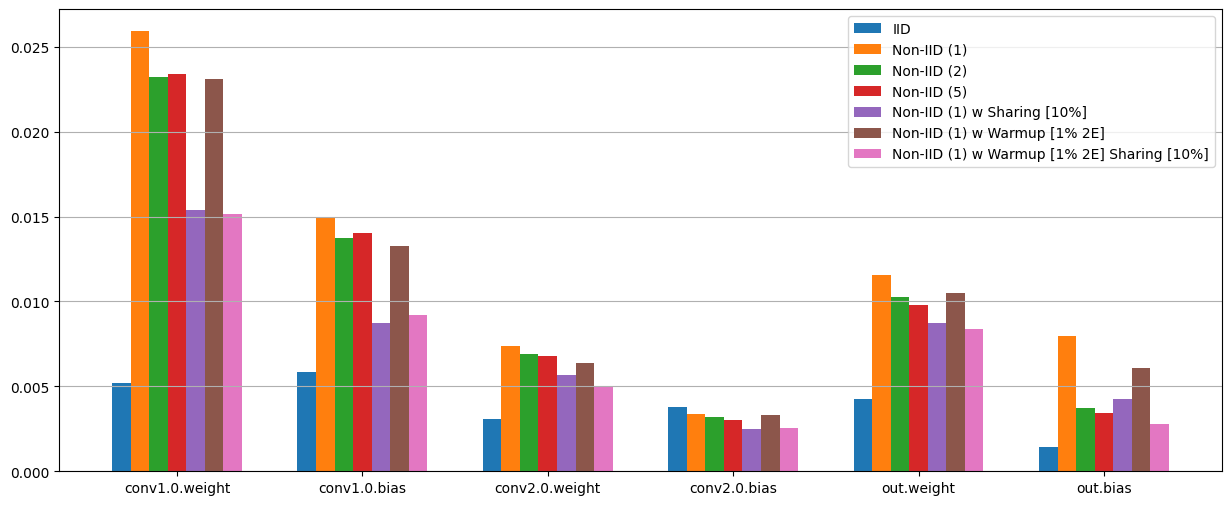

In [145]:
compare_divergence(hosts)

In [146]:
def compare_accuracy(hosts):
    plt.figure(figsize=(8, 6))
    for i in range(len(hosts)):
        plt.plot(range(1,ROUNDS+1),hosts[i].accuracies,marker='o',label=host_names[i])
    plt.title('Accuracy vs Communication Rounds')
    plt.grid(True)
    plt.legend()
    plt.show()

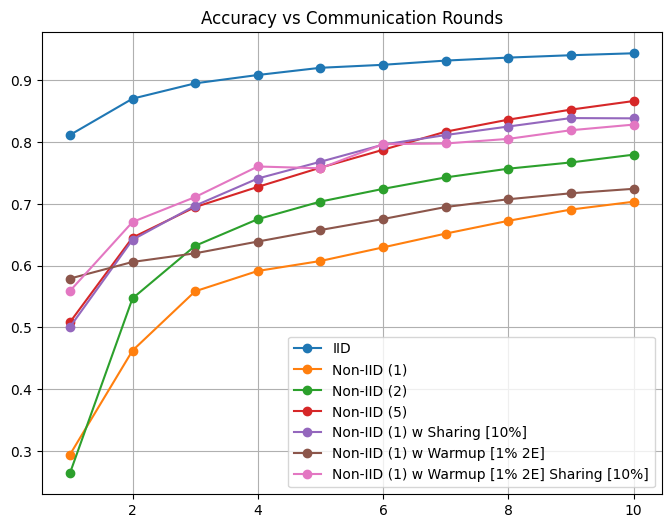

In [147]:
compare_accuracy(hosts)